* Policy gradients and deep Q-networks (DQNs)
* Markov decision processes (MDPs)
* The policy can be any algorithm you can think of, and it does not have to be deterministic. In fact, in some cases it does not even have to observe the environment!
* It may be programmed to get positive rewards whenever it approaches the target destination, and negative rewards whenever it wastes time or goes in the wrong direction.
* If the policy involves some randomness, it is called a stochastic policy
* Two policy parameters you can tweak: the probability p and the angle range r. This is an example of policy search, in this case using a brute force approach
* When the policy space is too large (which is generally the case), finding a good set of parameters this way is like searching for a needle in a gigantic haystack.
* Genetic algorithms. For example, you could randomly create a first generation of 100 policies and try them out, then “kill” the 80 worst policies6 and make the 20 survivors produce 4 offspring each. An offspring is a copy of its parent7 plus some 
random variation. The surviving policies plus their offspring together constitute the second generation. You can continue to iterate through generations this way until you find a good policy

In [36]:
from IPython import display
import numpy as np
import time
import gym
import PIL.Image
import io

* After the environment is created, you must initialize it using the reset() method. This returns the first observation.
* Each observation is a 1D NumPy array containing four floats: these floats represent the cart’s horizontal position (0.0 = center), its velocity (positive means right), the angle of the pole (0.0 = vertical), and its angular velocity (positive means clockwise).
* To display this environment by calling its render() method what actions are possible
* The step() method executes the given action and returns four values
    * obs > This is the new observation.
    * reward > In this environment, you get a reward of 1.0 at every step, no matter what you do
    * done > This value will be True when the episode is over.
    * info > This environment-specific dictionary can provide some extra information that you may find useful for debugging or for training
* Once finished using an environment, you should call its close() method to free resources

### Screenshot

[-0.01545023  0.01289725  0.03955405 -0.04210039]


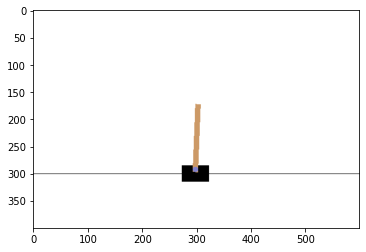

In [45]:
env = gym.make("CartPole-v1")
obs = env.reset()
print(obs)
plt.imshow(env.render(mode='rgb_array'))
env.close()

In [47]:
# That means that the possible actions are integers 0 and 1, which represent accelerating left (0) or right (1).
env.action_space

Discrete(2)

### Animation

In [37]:
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = io.BytesIO()
    ima = PIL.Image.fromarray(a).save(f, fmt)
    return f.getvalue()

In [51]:
def image(env):
    mode_rgb = env.render(mode='rgb_array')
    show = showarray(mode_rgb)
    return display.Image(data=show, width=450)

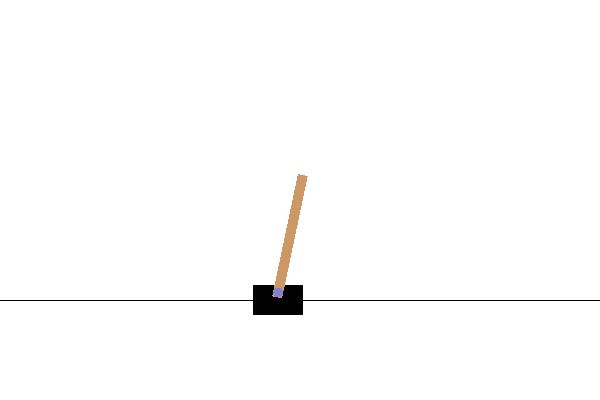

In [53]:
env = gym.make('CartPole-v0')
env.reset()

imagehandle = display.display(image(env), display_id='gymscr')

for _ in range(100):
    time.sleep(0.01)
    action = env.action_space.sample()
    env.step(action) # take a random action
    display.update_display(image(env), display_id='gymscr')

### Example1

In [49]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

Observation values
1. the cart’s horizontal position (0.0 = center), 
2. its velocity (positive means right), 
3. the angle of the pole (0.0 = vertical), 
4. its angular velocity (positive means clockwise)

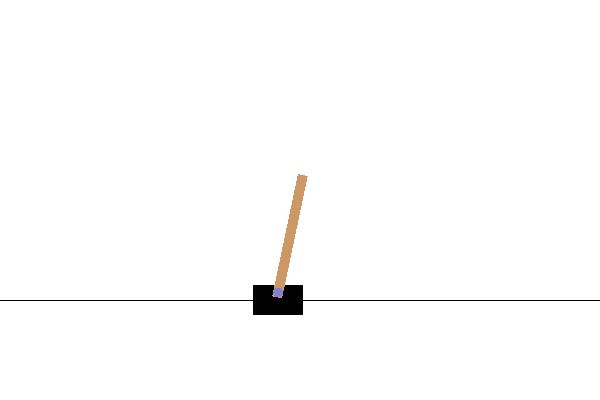

[ 0.00374958 -0.14652763 -0.0247879   0.25333453] 1.0 False {}
[ 0.00081903 -0.34128703 -0.01972121  0.53809699] 1.0 False {}
[-0.00600671 -0.53612625 -0.00895927  0.82450133] 1.0 False {}
[-0.01672924 -0.73112452  0.00753076  1.114353  ] 1.0 False {}
[-0.03135173 -0.53610225  0.02981782  0.82404192] 1.0 False {}
[-0.04207377 -0.34140059  0.04629866  0.54088439] 1.0 False {}
[-0.04890178 -0.14695894  0.05711635  0.26314141] 1.0 False {}
[-0.05184096  0.04730319  0.06237917 -0.01099354] 1.0 False {}
[-0.0508949   0.24147765  0.0621593  -0.28336115] 1.0 False {}
[-0.04606535  0.43566048  0.05649208 -0.5558098 ] 1.0 False {}
[-0.03735214  0.62994567  0.04537588 -0.83017284] 1.0 False {}
[-0.02475322  0.82441898  0.02877243 -1.10824661] 1.0 False {}
[-0.00826484  1.0191512   0.0066075  -1.39176612] 1.0 False {}
[ 0.01211818  1.21419025 -0.02122783 -1.68237573] 1.0 False {}
[ 0.03640198  1.01932046 -0.05487534 -1.39637741] 1.0 False {}
[ 0.05678839  0.82492237 -0.08280289 -1.12134447] 1.0 F

In [61]:
episode_rewards = 0
totals = []

env = gym.make('CartPole-v0')
obs = env.reset()
imagehandle = display.display(image(env), display_id='gymscr')
for _ in range(200):
    time.sleep(0.01)
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    print(obs,reward,done,info)
    if done: 
        print(obs,reward,done,info)
        break
    display.update_display(image(env), display_id='gymscr')
    totals.append(episode_rewards)

In [63]:
# finish after 35 observations
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(18.0, 10.099504938362077, 1.0, 35.0)

#### Neural Network Policies